In [2]:
# Step 1: Load the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset (replace the path with your actual file)
data = pd.read_csv('crypto_data.csv', parse_dates=['Timestamp'], index_col='Timestamp')

# Check the first few rows of the data
data.head()

# Step 2: Calculate Log Changes (Log-Returns) for Forecasting
data['Log_Close'] = np.log(data['Close'])

# Calculate the log change (percentage change in the log price)
data['Log_Change'] = data['Log_Close'].diff()  # This will be the target variable

# Drop NaN values that may appear due to the diff() operation
data = data.dropna()

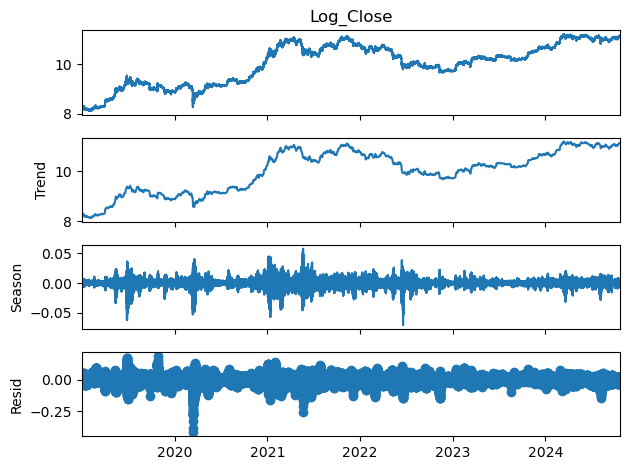

In [3]:
from statsmodels.tsa.seasonal import STL

# Step 3: STL Decomposition
seasonal_period = 96  # 15-minute intervals per day (96 intervals in 24 hours)
stl = STL(data['Log_Close'], period=seasonal_period, robust=True)
result = stl.fit()

# Get the decomposed components
data['STL_Trend'] = result.trend
data['STL_Seasonal'] = result.seasonal
data['STL_Residual'] = result.resid

# Plot the decomposed components
result.plot()
plt.show()


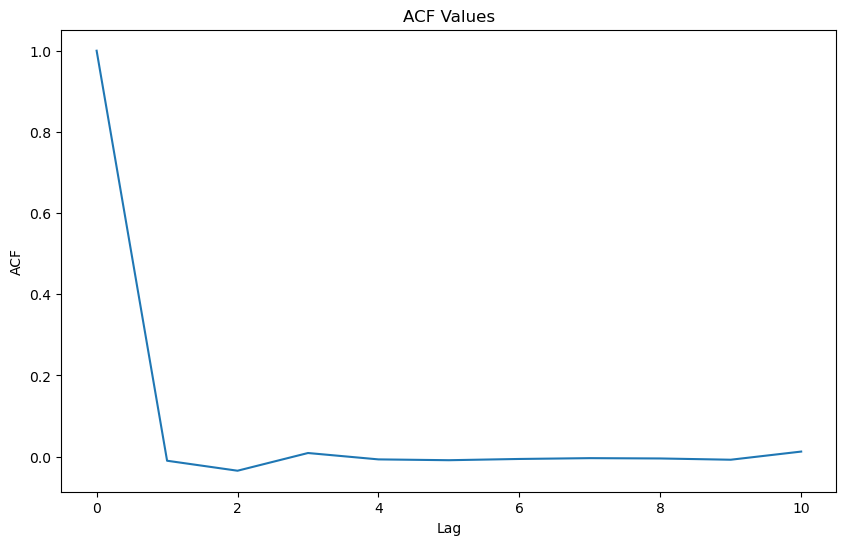

In [4]:
from statsmodels.tsa.stattools import acf

# Step 4: Calculate ACF Features
# Calculate ACF for different lags (you can adjust the number of lags as needed)
lags = 10  # Number of lags to consider for autocorrelations
acf_values = acf(data['Log_Change'], nlags=lags)

# The first autocorrelation
data['ACF_1'] = acf_values[1]  # ACF at lag 1

# Sum of squares of the first 10 autocorrelations
data['ACF_sum_sq'] = np.sum(acf_values[1:]**2)

# If you want more detailed ACF features, you can add higher-order lags as columns
for i in range(1, lags+1):
    data[f'ACF_{i}'] = acf_values[i]

# Plot ACF values for visual check
plt.figure(figsize=(10, 6))
plt.plot(range(lags+1), acf_values)
plt.title("ACF Values")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

In [19]:
X = data[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual', 'ACF_1', 'ACF_sum_sq']]
# Optional: You can add other lag features here if needed
lags=[10, 20, 30, 40, 50, 60]
for lag in lags:
    X[f'log_close/mean_{lag}'] = np.log(np.array(X['Close']) /  
                                            np.roll(np.append(np.convolve(np.array(X['Close']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
    X[f'log_return_{lag}'] = np.log(np.array(X['Close']) / np.roll(np.array(X['Close']), lag))

# Mean features for different lags
for lag in lags:
    X[f'mean_close/mean_{lag}'] = np.mean(X.iloc[:, X.columns.str.startswith(f'log_close/mean_{lag}')], axis=1)
    X[f'mean_log_returns_{lag}'] = np.mean(X.iloc[:, X.columns.str.startswith(f'log_return_{lag}')], axis=1)
    
# Features based on differences between the individual log features and their mean values
for lag in lags:
    X[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = np.array(X[f'log_close/mean_{lag}']) - np.array(X[f'mean_close/mean_{lag}'])
    X[f'log_return_{lag}-mean_log_returns_{lag}'] = np.array(X[f'log_return_{lag}']) - np.array(X[f'mean_log_returns_{lag}'])


y = data['Log_Change']  # Target is the log change for the next day

C:\Users\kyo\AppData\Local\Temp\ipykernel_17528\298949239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'log_close/mean_{lag}'] = np.log(np.array(X['Close']) /
C:\Users\kyo\AppData\Local\Temp\ipykernel_17528\298949239.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'log_return_{lag}'] = np.log(np.array(X['Close']) / np.roll(np.array(X['Close']), lag))
C:\Users\kyo\AppData\Local\Temp\ipykernel_17528\298949239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [20]:
X.head()

,Volume,Open,Close,High,Low,STL_Trend,STL_Seasonal,STL_Residual,ACF_1,ACF_sum_sq,...,log_close/mean_20-mean_close/mean_20,log_return_20-mean_log_returns_20,log_close/mean_30-mean_close/mean_30,log_return_30-mean_log_returns_30,log_close/mean_40-mean_close/mean_40,log_return_40-mean_log_returns_40,log_close/mean_50-mean_close/mean_50,log_return_50-mean_log_returns_50,log_close/mean_60-mean_close/mean_60,log_return_60-mean_log_returns_60
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:15:00,131.742721,3697.91,3694.20,3698.75,3690.56,8.223319,0.003820,-0.012620,-0.010058,0.001786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 00:30:00,171.877714,3693.96,3702.39,3705.00,3693.00,8.223348,0.002391,-0.009005,-0.010058,0.001786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 00:45:00,191.772890,3702.05,3700.31,3713.00,3695.02,8.223377,0.001861,-0.009066,-0.010058,0.001786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,139.872706,3700.20,3701.03,3702.73,3691.22,8.223406,0.001977,-0.009017,-0.010058,0.001786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:15:00,135.318759,3702.39,3699.25,3702.39,3695.46,8.223436,0.001489,-0.009039,-0.010058,0.001786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Step 6: Train LightGBM Model
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)

# Predict on test data
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)


In [30]:
# Step 8: Evaluate Model Accuracy (RMSE)
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE (Root Mean Squared Error) on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the RMSE value
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Root Mean Squared Error (RMSE): 0.0020


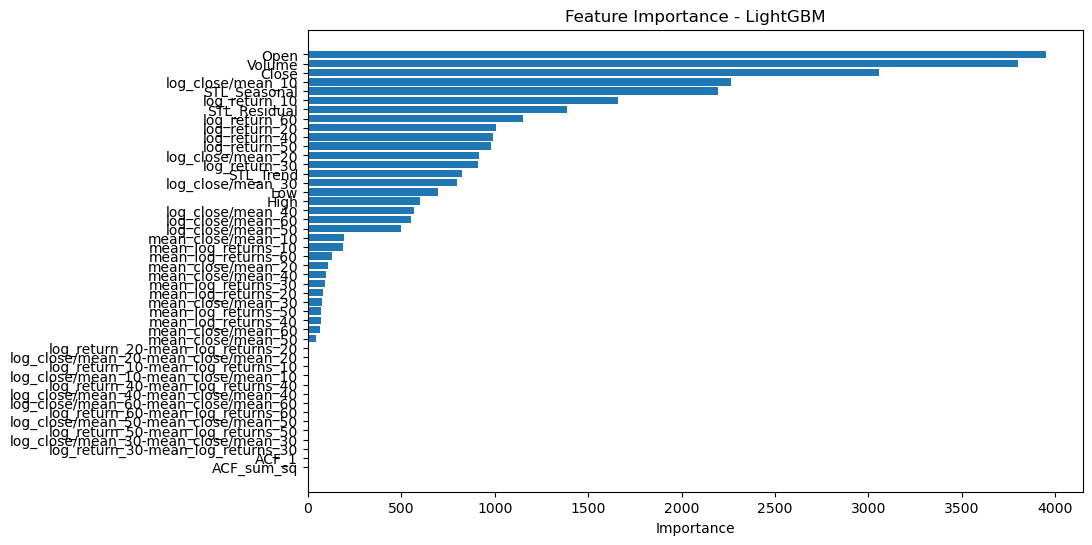

In [23]:
import matplotlib.pyplot as plt

# Plot feature importance using Matplotlib
importance = lgb_model.feature_importance(importance_type='split')
features = X.columns

# Sort features by importance
sorted_idx = importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance - LightGBM')
plt.show()


Final portfolio value: $5847.21
Total return: 484.72%
Number of trades executed: 1
Trade log: ['Buy at 20007.168997036802']


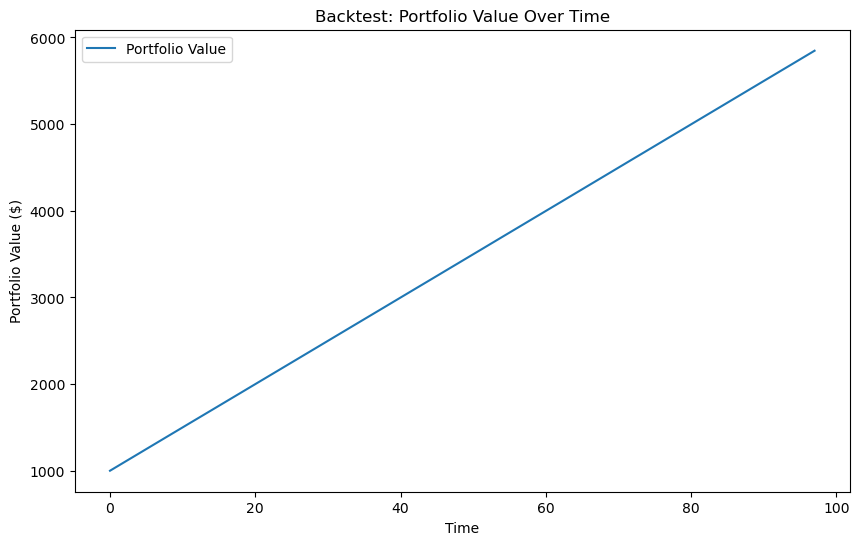

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

initial_balance = 100000
trading_balance_ratio = 1

threshold_values = [1e-07]
total_profits = []
drawdowns = []
trade_counts = []
win_ratios = []
average_profits = []
df_pred['position'] = 0

for threshold in threshold_values:
    current_balance = initial_balance
    current_position = 0
    entry_price = 0
    trades = []
    portfolio_values = [initial_balance]
    win_trades = 0
    loss_trades = 0
    peak_balance = initial_balance
    max_drawdown = 0

    for i in tqdm(range(len(df_pred))):
        if current_position == 0 and df_pred.iloc[i]['Predict'] > threshold:
            current_position = 1
            entry_price = df_pred.iloc[i]['Close']
            entry_time = df_pred.iloc[i]['timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = 1
            
        elif current_position == 1 and df_pred.iloc[i]['Predict'] < 0:
            current_position = 0
            exit_price = df_pred.iloc[i]['Close']
            exit_time = df_pred.iloc[i]['timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = -1
            trade_return = (exit_price - entry_price) / entry_price
            trade_profit = trade_return * min(99000, current_balance)
            current_balance += trade_profit
            trade_duration = exit_time - entry_time
            trades.append((entry_price, entry_time, exit_price, exit_time, trade_return, trade_duration, current_balance))
            if trade_profit > 0:
                win_trades += 1
            else:
                loss_trades += 1

        portfolio_values.append(current_balance)
        peak_balance = max(peak_balance, current_balance)
        drawdown = (peak_balance - current_balance) / peak_balance * 100
        max_drawdown = max(max_drawdown, drawdown)

    total_profit = (current_balance - initial_balance) / initial_balance * 100
    average_profit_per_trade = total_profit / len(trades) if trades else 0
    win_ratio = win_trades / len(trades) if trades else 0

    total_profits.append(total_profit)
    drawdowns.append(max_drawdown)
    trade_counts.append(len(trades))
    win_ratios.append(win_ratio)
    average_profits.append(average_profit_per_trade)